# Tecnologias de Processamento de dados - 2019/2020

## Phase III - Group 12


Student|Student ID|Contribution in hours
-|-|-
Beatriz Lima|49377|<center>10h</center>                      
David Almeida|54120|<center>10h</center>                  
João Castanheira|55052|<center>10h</center>                       
Pedro Cotovio|55053|<center>10h</center>

# 0. Schema alterations


We realised that in the Date dimension, we have the `Month` column as integer. We think that having these attributes as categorical would help in interpretability. To avoid having to drop the whole database (given the referential contraints), we simply added a column `Month_name`to the existing date table.

In [4]:
#1. Libraries
import psycopg2 as pg
import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
import os
from db_connection import dbconnection as db
from IPython.display import SVG

In [2]:
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
db.run_sql_command("ALTER TABLE date ADD month_name VARCHAR(20)", conn)

In [10]:
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
q = sqlio.read_sql_query("SELECT date_id, month FROM DATE", conn)

In [ ]:
q = q.set_index('date_id', drop=True)

dic = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September',
       10: 'October', 11: 'November', 12:'December'}

for index, row in q.iterrows():
    print(index)
    conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
    stm = "UPDATE date SET month_name = '"+str(dic[row['month']])+"' WHERE date_id = "+str(index)
    db.run_sql_command(stm, conn)

# 1. OLAP Queries

##  a. Previously defined queries

Check and revise the queries defined in Phase I. Ensure that the queries are meaningful for the processes at hand.

![Bus matrix](imagesIII/bus_matrix.png)

The rest of these queries were defined in Phase I:

Demand queries (relative to the Bookings fact table):
 - The calendar period in which properties are available or not;
 - Locations where the properties are most available;
 - Correlation between host profile and demand for their listings;
 - The types of properties that are most sought after.

We realised that the first query is not really an OLAP query, but rather just a simple interrogation on our bookings fact table. The rest of the queries and are still relevant for understanding the demand and the clients behaviour or preferences. We think that it might be interesting to pursue the analysis of the most popular locations in each time of the year.

Supply queries (relative to the Listings fact table):
 - Number of listings by parish or county, and their evolution over time;
 - Use the Review dimension to check in which parishes the listings with high review scores are located;
 - Check price evolution across differents locations;
 - Locations where hosts have listings in comparison to their listed residence (“Are hosts residents in foreign countries?”, “Are they investors from richer countries?”);
 - Analyse the evolution over time and across locations, of types of properties using the Property dimension, providing an overview on what the platform can supply.
 
 ###### Comment on relevance of these queries... Including CRM


## b. For each query type identify dimensions, attributes and measures for each one

- **Query 1**) hottest months/dates and most popular locations.
This analysis involves the date and location dimensions, and the bookings fact table. We will try different grains of detail, going from months to seasons, etc. The same goes for the location, where the hierarchy of parish and county will be explored through roll up or down operations. We will also try to establish an association with the income generated from bookings.


- **Query 2**) locations where hosts have listings in comparison to their listed residence.
This query looks at the ownership of Airbnb-listed properties by extracting information about listings' locations and their respective hosts' locations. It will make use of two dimensions, Location and Host, associated with the Listings fact table. In this way, we can understand how ownership is distributed, that is, if listings are hosted by locals, or by foreigners that have invested in properties abroad.


- **Query 3**) The purpose for this query is to analyze the evolution over time and across time, of types of properties using the Property dimension.
This analysis involves the listings fact table, and the location, property and date dimensions. In order to run this query, will be used the attribute _property_type_category_ from Property dimension, the attribute _parish_ from the Location dimension and the attribute _year_ from Date dimension. The idea is to group the listings by the attributes described above, in order to count the number of listings across time (by year) grouped by parish and property type category. With this query we can see how the Airbnb business evolved during the last years.


- **Query 4**) The purpose of this query is to create metrics that serve to rank the available properties, and to create useful CRM KPIs. The ranking can then be used to determine the characteristics of the top 10 properties, while the KPIs provide useful information into the company’s performance.
This query uses both facts tables, listings, and bookings, and centralize in the properties dimension, accessing also reviews and date dimensions.
The metrics are normalized between 0 and 1 and attributed to every property. There are two metrics, customer satisfaction, which is the average of the sum of the review parameters for every property. And the monthly profit, this could be more accurately depicted as income, which is the product of the average number of days rented per month by average price per night per property. There is a third metric that is used for the ranking that is the sum of the two, which can be regarded as the property’s performance.
The KPI’s represent this metrics on a global scale for the company, clearly showing the company’s performance.

## c. SQL queries 
Write the SQL queries and execute them. Make sure the results are understandable

### Query 1 -  hottest months/dates and most popular locations 

The motivation for this query is to keep track of the costumers' preferences, in order to monitorize demand and provide a basis for strategy planning for expansion. Airbnb would want to focus on certain locations, in order to meet the demand.

It is important to keep in mind that since our data was obtained via web scrapping, we were only able to obtain the future bookings (after January 2020). In that sense, this analysis serves as monitoring of current bookings and income prediction, but it could be easily extended to history analysis, provided the data.

In [33]:
create_bookings_view= """
DROP VIEW bookings_income;
CREATE VIEW bookings_income AS
SELECT d.season, d.month_name, l.street, l.parish, l.coastal_area, count(*) as nr_bookings,  b.price_per_night, count(*)*b.price_per_night as income
FROM date d, booking b, location l
WHERE b.date_id = d.date_id
AND b.location_id = l.location_id
GROUP BY d.season, d.month_name, l.street, l.parish, l.coastal_area, b.price_per_night
ORDER BY income DESC;

SELECT * FROM bookings_income LIMIT 10;
"""

In [34]:
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = sqlio.read_sql_query(create_bookings_view, conn)

In [35]:
q_view = sqlio.read_sql_query("SELECT * FROM bookings_income LIMIT 10", conn)

In [36]:
q_view

,season,month_name,street,parish,coastal_area,nr_bookings,price_per_night,income
0,Winter,January,RUA CASTANHEIROS,Quinta da Marinha,Coastal Area,15,8000,120000
1,Summer,August,AVENIDA ATLÂNTICO,Pinhal da Nazaré,Coastal Area,28,628,17584
2,Spring,May,TRAVESSA DO PINHEIRO,Lisboa,Coastal Area,10,1300,13000
3,Summer,July,AVENIDA ATLÂNTICO,Pinhal da Nazaré,Coastal Area,17,628,10676
4,Summer,June,1ª RUA DA QUINTINHA,Lisboa,Coastal Area,24,400,9600
5,Spring,April,AVENIDA ATLÂNTICO,Pinhal da Nazaré,Coastal Area,20,415,8300
6,Summer,August,RUA CASAIS,Casais de Cabrela,Coastal Area,27,300,8100
7,Summer,July,1ª RUA DA QUINTINHA,Lisboa,Coastal Area,20,400,8000
8,Spring,April,TRAVESSA DO PINHEIRO,Lisboa,Coastal Area,6,1300,7800
9,Summer,July,TRAVESSA DO PINHEIRO,Lisboa,Coastal Area,7,1100,7700


Looking at the top 10 locations in terms of revenue, we could roughly conclude that:
- Airbnb will be able to produce revenue all seasons of this year, having at least one top 10 high-income listing per season.
- Most of the high-income bookings happen in the Summer.
- Regardless of the season, Airbnb Lisbon clients prefer properties in the coastal area.
- Some places have fewer bookings per season (for example, Quinta da Marinha) but since the price per night is so high, they end up bringing high income.

These conclusions need to be taken with a grain of salt, since we are only looking at the top 10 high-income listings. In order to understand the bigger picture, we will be looking at the income from bookings by location and season.

In [55]:
query_summer = """
SELECT parish, SUM(income) as income_summer
from bookings_income 
where season = 'Summer' 
group by parish, season 
ORDER BY parish;
"""

query_winter = """
SELECT parish, SUM(income) as income_winter
from bookings_income 
where season = 'Winter' 
group by parish, season 
ORDER BY parish;
"""

query_total_season = """
SELECT NULL, season, SUM(income) as income
FROM bookings_income
GROUP BY season
"""

query_total_parish = """
SELECT parish, NULL, SUM(income) as yearly_income
FROM bookings_income
GROUP BY parish
"""

query_total_total = """
SELECT NULL, NULL, SUM(income) as income
FROM bookings_income
"""

In [56]:
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
summer_df = sqlio.read_sql_query(query_summer, conn)
winter_df = sqlio.read_sql_query(query_winter, conn)
total_season = sqlio.read_sql_query(query_total_season, conn)
total_parish = sqlio.read_sql_query(query_total_parish, conn)
total_parish.drop('?column?', axis=1, inplace=True)
total_total = sqlio.read_sql_query(query_total_total, conn)

In this table we present the total income in the summer, winter and whole year. We also present the percentual gain in income from summer to winter.

In [59]:
df_merge_q1 = pd.merge(summer_df,winter_df, how='inner', on='parish')
df_merge_q1['percentual_gain%'] = ((df_merge_q1.income_winter - df_merge_q1.income_summer)*100/ df_merge_q1.income_summer).round(2)
df_merge_q1 = pd.merge(df_merge_q1, total_parish, how='inner', on='parish')
df_merge_q1

,parish,income_summer,income_winter,percentual_gain%,yearly_income
0,Adão Lobo,5393.0,2240.0,-58.46,14080.0
1,Algés,385.0,825.0,114.29,1375.0
2,Almoçageme,10472.0,8058.0,-23.05,29432.0
3,Assafora,3250.0,250.0,-92.31,3500.0
4,Belas,6900.0,4275.0,-38.04,20325.0
5,Casais de Cabrela,18940.0,5610.0,-70.38,40310.0
6,Casais de Monte Bom,1825.0,10175.0,457.53,12000.0
7,Cascais,23058.0,12613.0,-45.30,68755.0
8,Charneca,8775.0,195.0,-97.78,8970.0
9,Ericeira,10440.0,4147.0,-60.28,19989.0


The total income by season:

In [63]:
total_season

,?column?,season,income
0,None,Spring,588104.0
1,None,Winter,528624.0
2,None,Summer,635485.0
3,None,Autumn,347743.0


The total income for Airbnb Lisbon in 2020-2021 (so far):

In [61]:
total_total['income']

0    2099956.0
Name: income, dtype: float64

**Conclusions and comments:**

Generally, there is more income in the summer. This difference is even more noticeable in beach destinations such as Praia das Maçãs and Assafora. The preffered destinations for the winter are Algés, Casais de Monte Bom and Quinta da Marinha. Autumn is the worse season in terms of income.

The parish with the highest income is Lisboa, being nearly as popular in the summer and the winter (-20.04% in the winter compared to summer).

GROUP BY CUBE and GROUP BY ROLL UP are OLAP extensions in SQL that would highly improve this query in terms of optimizing the aggregate values calculation and simplifying the query itself. Instead of having four interrogations, we could obtain the sums of incomes with just one interrogation. Unfortunately, GROUP BY CUBE is not available in postgreSQL yet, and GROUP BY ROLL UP is not implemented in the version of postgreSQL available at our server.

In the development of this work, other grains of detail were explored through roll down operations on the date and location hierarchies. For the sake of keeping conclusions light, we only present the broader results.

### Query 2 - property ownership characteristics

In [12]:
query2 = """
DROP VIEW IF EXISTS query2;

CREATE VIEW query2 AS
SELECT
    location.street, location.parish, location.county,
    host.host_country, host.host_continent, host.host_country_gdp, host.membership_duration,
    count(*)
FROM 
	listings,
	location,
	host
WHERE
	location.street LIKE '%' AND
	listings.location_id = location.location_id AND
	listings.host_id = host.host_id
GROUP BY
	location.street, location.parish, location.county,
    host.host_country, host.host_continent, host.membership_duration, host.host_country_gdp
ORDER BY street ASC, count DESC;

SELECT * FROM query2
"""

In [13]:
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
q2_df = sqlio.read_sql_query(query2, conn)
conn = None

In [14]:
q2_df.to_csv('q2.csv')
display(q2_df)

,street,parish,county,host_country,host_continent,host_country_gdp,membership_duration,count
0,1ª CANADA RUA DO CARDAL,Lisboa,Lisboa,Portugal,Europe,20k - 35k,Member for more than 5 years,1
1,1ª RUA 18,Barcarena,Oeiras,Portugal,Europe,20k - 35k,Member for more than 2 years,1
2,1ª RUA 5 DE OUTUBRO,Ericeira,Mafra,Portugal,Europe,20k - 35k,Member for more than 5 years,2
3,1ª RUA 5 DE OUTUBRO,Ericeira,Mafra,Germany,Europe,35k - 50k,Member for more than 5 years,1
4,1ª RUA 61,Lisboa,Lisboa,Portugal,Europe,20k - 35k,Member for more than 5 years,1
...,...,...,...,...,...,...,...,...
4648,ZONA ESCOLAS GERAIS,Lisboa,Lisboa,Portugal,Europe,20k - 35k,Member for more than 5 years,3
4649,ZONA ESCOLAS GERAIS,Lisboa,Lisboa,Portugal,Europe,20k - 35k,Member for more than 2 years,2
4650,ZONA ESCOLAS GERAIS,Lisboa,Lisboa,Portugal,Europe,20k - 35k,Member for more than 1 year,1
4651,ZONA SÍTIO DO CASTELO,Cascais,Cascais,Portugal,Europe,20k - 35k,Member for more than 5 years,2


In [15]:
idx = input("Choose property location attribute to cross:")
col = input("Choose host residence attribute to cross:")

q2_pivot = pd.pivot_table(q2_df, values = 'count', index = idx, columns = col, aggfunc = sum, margins = True)
display(q2_pivot)

Choose property location attribute to cross:parish
Choose host residence attribute to cross:host_country


host_country,Angola,Australia,Austria,Belgium,Brazil,Canada,China,Denmark,Finland,France,...,Spain,Sri Lanka,Sweden,Switzerland,Turkey,United Arab Emirates,United Kingdom,United States,Vietnam,All
parish,,,,,,,,,,,,,,,,,,,,,
A dos Cunhados,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
Abelheira,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
Abrunheira,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
Achada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
Adão Lobo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vimeiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Várzea de Sintra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
Zambujal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


The motivation behind this query is the business interest in profiling and targetting. Naturally, for a business to expand and succeed, it must identify its target audience and its goal market, so as to intervene in this space and promote its role there. In the business intelligence side, how is it possible to accurately identify who is using a service? This is achieved by analysing customer/client data.

For the Airbnb model, there are two types of targets: customers, a.k.a. tourists, which seek to use Airbnb's platform to book a stay or an experience somewhere, and hosts, which use Airbnb's platform to advertise their properties and services to a broader audience. Both are essential, of course, for this business model to work: they work as demand and supply, respectively, and must coexist in a balanced fashion. Airbnb profits from both: more clients lead to more bookings, which generate direct revenue from the fee Airbnb takes from every listing, and more hosts expands the options Airbnb offers, increasing the likelihood clients will have something to their taste, and increasing the number of revenue sources.

This query seeks to profile hosts in a manner that understands their geo-economical context. This is an important insight to obtain. Customer data would be even more precious for this type of analysis, however, such data is not at our disposal, and as such, we opted for this approach to work as a sort of proof-of-concept.

For this, we extract information about the host's location of residence and cross it with their owned properties' information, in order to understand if there are interesting patterns in property ownership according to host characteristics. The pivot table format makes the interpretation of this data much clearer by crossing fields of interest.

If implemented in a more user-friendly manner, attribute selection for the pivot table would have a more intuitive interface. With the _.csv_ file produced, it's possible to create a data visualisation dashboard that eases interpretation and analysis. For this, we used the software Power BI.

Via Wikidata's SPARQL Query Tool, it's possible to obtain many different kinds of data. Geographical coordinates for Portuguese parishes were extracted from the database using an appropriate query and downloaded as a _.csv_ file. Both _.csv_ were uploaded to Power BI, related by their attribute "Parish", and, in this way, the number of properties in each geographical location can be associated with their place on a map.

Other options, such as importing additional geographical data (for counties, for example, and other countries, if the dataset encompassed more than one country), would also result in interesting visualisations to analyse with distinct levels of granularity.

Below, we can see the resulting dashboard. Each circle is proportional to the number of properties in the corresponding location, and it's sliced in a pie chart to denote which countries the hosts are residents of. Other host characteristics could be selected to define the pie chart.

<img src="imagesIII/DashboardQ2.png" alt="Power BI Query 2 Dashboard" width="1000"/>

Properties owned by Portugal residents are in the majority, as was expected. Richer countries, such as the UK, USA and European countries seem to be the countries of residence of many foreign hosts.

### Query 3 - Analyse the evolution over time and across locations of types of properties 

The puporse of this query is to provide an overview on what the platform can supply.


In the cell bellow we define the SQL query

In [10]:
query3 = """
    select d.year, lo.parish, p.property_type_category, count(*) from listings l
    inner join property p on p.property_id = l.property_id
    inner join date d on d.date_id = l.date_id
    inner join location lo on lo.location_id = l.location_id
    group by d.year, lo.parish, p.property_type_category
    order by d.year, lo.parish, p.property_type_category asc
"""

Now lets connect to the database and run the query, by saving it in the _q3_df_ object

In [51]:
%%time
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode,gssencmode=db.gssencmode)
q3_df = sqlio.read_sql_query(query3, conn)
conn = None
q3_df.shape

Wall time: 55.9 ms


(727, 4)

This are the first 5 results that the query returns, ordered by year. For each year, we have the amount of new listings available by parish and property_type_category. We have very old because dates, this is because we joined our listings data with the 'alojamento_local.csv', which contains data provided by the Ministry of Tourism. The 'year' column corresponds to the year of registry of the property according to the ministry of tourism data, and not the year of registry in the airbnb platform.

In [50]:
q3_df.head()

,year,parish,property_type_category,count
0,1967,Queluz,Apartment,3
1,1970,Lisboa,Apartment,1
2,1985,Lisboa,Apartment,2
3,1986,Praia Grande,House,1
4,1998,Samarra,House,3


To analyse this data we would use PoweBI. Here we export the dataframe, in order to import it to PowerBI

In [ ]:
q3_df.to_csv('query3.csv')

Now lets plot the visualization provided by PowerBI

<img src="imagesIII/DashboardQ3.png" alt="Power BI Query 3 Dashboard" width="1000"/>

We can see that the major listings are located in Lisbon parish. We can also see that in Lisbon parish the major listings are of type 'Apartament', while as we move to the city outskirts we start to see more properties of type 'House'. By using PowerBI it is possible to filter the query by property type and by year. With that we can see the evolution of listings during time, as we can see in the image bellow.

<img src="imagesIII/DashboardQ3Filter.png" alt="Power BI Query 3 filter Dashboard" width="1000"/>

Now lets plot the evolution of new listings per year, by property type over time.

Text(0, 0.5, 'New listings')

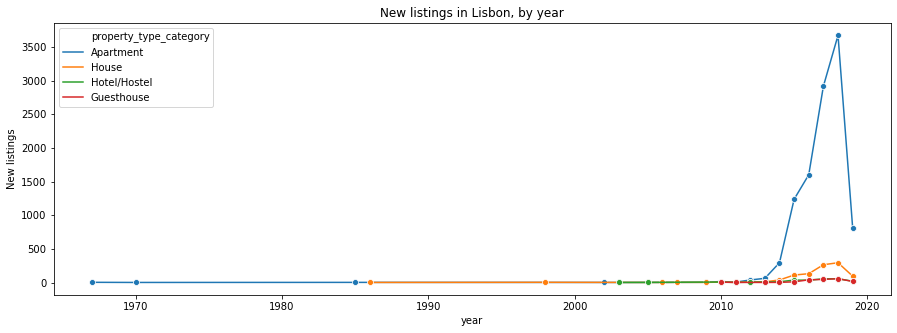

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
df_plot = q3_df[['year','property_type_category','count']].groupby(['year','property_type_category']).sum().reset_index()
#remove 2020 data, because it is incomplete
df_plot = df_plot[df_plot['year'] != 2020]
#plotww
plt.figure(figsize=(15,5))
sns.lineplot(x='year',y='count',hue='property_type_category', data = df_plot, marker="o")
plt.title('New listings in Lisbon, by year')
plt.ylabel('New listings')

We can see that the major of new listings in Lisbon are of type Apartments. Since 2013 the number of new listings per year started to increase exponentially, until 2019, where it decreases from more than 3500 new listings in 2018 to less than 1000 new listings in 2019. In that plot was not considered the 2020 year since we would have incomplete data.

### Query 4 - Costumer relationship management

**Pre-Process** In order to facilitate queries we will redo the Reviews Dimension using numerical variables.

In [20]:
# Retreive Current Reviews
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
table_name = 'review'
df_reviews = db.query_table(conn, table_name)
df_reviews.head()

,review_id,rating,accuracy,cleanliness,communication,location
0,1,Very good,Description is not accurate,Clean,Good communication,Good location
1,2,Average,Description is not accurate,Clean,Good communication,Good location
2,3,Good,Description is not accurate,Clean,Good communication,Good location
3,4,Bellow average,Description is not accurate,Clean,Good communication,Good location
4,5,Average,Description is not accurate,Clean,Bad communication,Good location


In [23]:
# Map Categorical Reviews to Numerical Values

mapping = {
    'rating': {
        'Bellow average': 0,
        'Average': 1,
        'Good': 2,
        'Very good': 3,
        'Excelent': 4
    },
    'accuracy': {
        'Description is not accurate': 0,
        'Accurate description': 1
    },
    'cleanliness': {
        'Not clean': 0,
         'Clean': 1
    },
    'communication': {
        'Bad communication': 0,
        'Good communication': 1
    },
    'location': {
        'Bad location': 0,
        'Good location': 1
    }
}
try:
    df_reviews.replace(mapping, inplace=True)
except TypeError:
    pass

# Add Sum Column
df_reviews['score'] = df_reviews.sum(axis=1)
df_reviews.head()

,review_id,rating,accuracy,cleanliness,communication,location,score
0,1,3,0,1,1,1,7
1,2,1,0,1,1,1,6
2,3,2,0,1,1,1,8
3,4,0,0,1,1,1,7
4,5,1,0,1,0,1,8


**Inject database**

In [ ]:
# Insert Table
insert_sql = """
DROP TABLE IF EXISTS CS; 
CREATE TABLE CS (
REVIEW_ID SERIAL PRIMARY KEY NOT NULL,
RATING INT NOT NULL, 
ACCURACY INT NOT NULL,
CLEANLINESS INT NOT NULL,
COMMUNICATION INT NOT NULL,
LOCATION INT NOT NULL,
SCORE INT NOT NULL
);
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
db.run_sql_command(insert_sql, conn)

# Insert DATA
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
db.insert_data(df_reviews, 'CS', conn)

# Insert Constraints
insert_c = """
ALTER TABLE listings
DROP CONSTRAINT IF EXISTS constraint_fkey;
ALTER TABLE listings 
ADD CONSTRAINT cn FOREIGN KEY (review_id) REFERENCES CS (review_id);
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(insert_c, conn)
if success is True: print('Done')

#### KPI's

A KPI is a measurable value that demonstrates how effectively a company is achieving key business objectives. We decided to create some KPIs in order to better evaluate the companies' interests through our queries.

The metrics are normalized, meaning that 100% represents the best case scenario where all the properties are maximizing their potential.

* Customer Satisfaction, where in a best-case scenario all properties would have maximum ratings.
* Monthly Profit Per Property, where in a best-case scenario all properties would be as profitable as the most profitable property.
* Company’s Performance is a combination of the previous two and shows how much of their potential the company is currently tapping into.

In [27]:
# Create Metrics View

# Normalized Customer Satisfaction Metric
norm_cs_sql = """
CREATE OR REPLACE FUNCTION normalized_cs()
RETURNS TABLE
            (
                id INT,
                normalized_cs NUMERIC
            )
AS $$
BEGIN
RETURN QUERY
    SELECT
    x.id, 1.00*(sample-min_metric)/range_metric
    FROM
        (
        SELECT
               cs.id,
               metric AS sample,
               MIN(metric) OVER () AS min_metric,
               MAX(metric) OVER () - MIN(metric) OVER () AS range_metric
        FROM
             (SELECT property.property_id as id, cs.score as metric
                FROM cs
                    INNER JOIN listings
                        ON cs.review_id = listings.review_id
                    INNER JOIN property
                        ON listings.property_id = property.property_id
                ) as cs
        ) x ;

END;
$$ LANGUAGE plpgsql;
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(norm_cs_sql, conn)

# Normalized Profit Metric
norm_profit_sql = """
CREATE OR REPLACE FUNCTION normalized_profit()
RETURNS TABLE
            (
                id INT,
                normalized_profit NUMERIC
            )
AS $$
BEGIN
RETURN QUERY
    SELECT
    x.id, 1.00*(sample-min_metric)/range_metric as normalized_profit
    FROM
        (
        SELECT
               cs.id,
               metric AS sample,
               MIN(metric) OVER () AS min_metric,
               MAX(metric) OVER () - MIN(metric) OVER () AS range_metric
        FROM
             (SELECT p.id, AVG(rented_days * avg_price_per_night)/30 as metric
                FROM (
                     SELECT CAST(count(*) as NUMERIC) as rented_days, booking.property_id as id, AVG(booking.price_per_night) as avg_price_per_night
                     FROM booking
                              INNER JOIN date
                                         ON booking.date_id = date.date_id
                     GROUP BY property_id, month, year
                     ) as p
                GROUP BY p.id
             ) as cs
        ) x ;

END;
$$ LANGUAGE plpgsql;
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(norm_profit_sql, conn)

In [31]:
# Create View

metrics_sql = """
CREATE VIEW IF NOT EXISTS metrics AS
    SELECT normalized_cs.id, avg(normalized_cs) as cs, avg(normalized_profit) as profit, avg(normalized_cs + normalized_profit) as score
    FROM normalized_cs(), normalized_profit()
    WHERE normalized_cs.id = normalized_profit.id
    GROUP BY normalized_cs.id;
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(metrics_sql, conn)

# Test
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
test = db.query_table(conn, 'metrics')
test.head()

,id,cs,profit,score
0,1,0.053198,0.147830,0.201028
1,2,0.066290,0.151472,0.217762
2,3,0.054701,0.789456,0.844157
3,4,0.064919,0.065337,0.130256
4,5,0.034074,0.068080,0.102154


In [7]:
# get KPI's

conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
cs = db.query_kpis(conn, method='cs')
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
profit = db.query_kpis(conn, method='profit')
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
score = db.query_kpis(conn, method='score')

# Print
print('Average KPIs for our listings:')
print('Customer Satisfaction {}%'.format(cs))
print('Monthly Profit Per Property {}%'.format(profit))
print("Company's Performance {}%".format(score))

OperationalError: could not connect to server: Operation timed out
	Is the server running on host "appserver-01.alunos.di.fc.ul.pt" (194.117.22.70) and accepting
	TCP/IP connections on port 5432?


**TOP 10 Ranking Properties according to KPIs (reviews and profitability)**

In [35]:
# Function to get top N ranking properties
topn_sql = """
CREATE OR REPLACE FUNCTION topN(N int)
RETURNS TABLE
            (
                id INT,
                score NUMERIC,
                property_type VARCHAR,
                room_type VARCHAR,
                accommodates VARCHAR,
                bathrooms VARCHAR,
                bedrooms VARCHAR,
                beds VARCHAR,
                bed_type VARCHAR
            )
AS $$
BEGIN
RETURN QUERY
    SELECT metrics.id, metrics.score/2, property.property_type,
           property.room_type, property.accommodates, property.bathrooms, property.bedrooms,
           property.beds, property.bed_type
    FROM metrics
    INNER JOIN property
        ON metrics.id = property.property_id
    ORDER BY metrics.score desc
    LIMIT N;
END;
$$ LANGUAGE plpgsql;
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(topn_sql, conn)

# Retrieve Properties
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
top10 = db.query_table(conn, 'topN(10)')
top10

,id,score,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type
0,128,0.500000,House,Entire home/apt,Up to 4 guests,3 bathrooms,T2,4+ beds,Real Bed
1,3,0.422078,Apartment,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
2,92,0.330318,Villa,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
3,51,0.285870,Apartment,Entire home/apt,Up to 7 guests or more,3 bathrooms,T3,4+ beds,Real Bed
4,147,0.222839,Villa,Entire home/apt,Up to 7 guests or more,3 bathrooms,T4+,4+ beds,Real Bed
5,23,0.218349,Apartment,Entire home/apt,Up to 7 guests or more,2 bathrooms,T4+,4+ beds,Real Bed
6,13,0.206479,Apartment,Entire home/apt,Up to 7 guests or more,3 bathrooms,T4+,4+ beds,Real Bed
7,126,0.204479,House,Entire home/apt,Up to 7 guests or more,2 bathrooms,T4+,4+ beds,Real Bed
8,48,0.178228,House,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
9,112,0.173954,Apartment,Entire home/apt,Up to 7 guests or more,1 bathroom,T4+,4+ beds,Real Bed


Properties in the top 10 are mostly big properties that accommodate many guests, some interesting characteristics are:

* All are private properties
* Accommodate mostly 7 or more guests
* Have 4+ Beds
* All beds are real beds and not couches
* Scores are at maximum 50%, so properties are not near their full potential

# 2. Bottlenecks

##  a. / b. Most important bottlenecks and performance analysis +  Plan for improving performance
Identify the most important bottlenecks and execute performance analysis

### Query 1

This query can be divided in two steps: first creating the view with aggregated values and then querying it in order to obtain more aggregated values by parish or season.

1. Creating the view

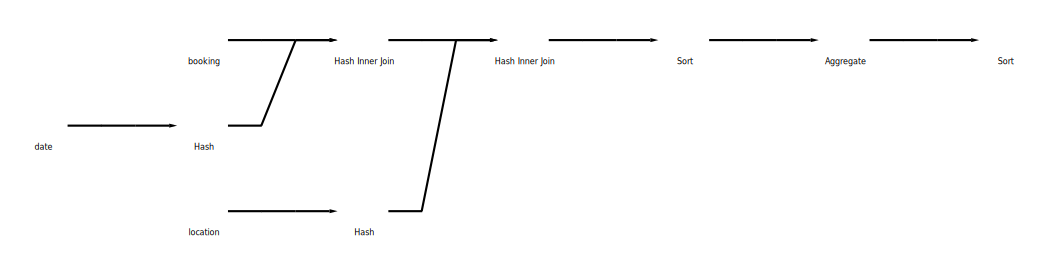

In [5]:
display(SVG(filename='imagesIII/explain_plan_1590928051045.svg'))

Total query runtime: 924 msec.

In this query we use the hash indexes automatically generated for the primary keys, in order to optimize the JOIN operations. This is a costly operation as we need to sort the results twice (one for the GROUP BY and another for the ORDER BY income). Maybe a b+tree index on the attributes used for aggregation could benefit the query's performance. Still, the best solution for this bottleneck would be to create a materialized view, which persists the results in a table-like form. 

2. Income tables

Since the rest of the operations are done over the bookings_view, we cannot create indexes on attributes. If we had a materialized view, we think that an index on `season` could benefit the query's performance, since we filter by season in the WHERE clause.

### Query 2

In [1]:
display(SVG(filename='imagesIII/q2_plan1.svg'))

NameError: name 'SVG' is not defined

This query already works with significant speed. However, a materialized view is a candidate to reduce computation time for this query. In this way, every time the query was run, only the view table would need to be consulted, and all aggregations and sortings would have been done already. But a materialized view benefits most the cases where queries are run often and updates aren't constant, because in this way, the view table available is already pre-computed with all the necessary data.

Overall, this query wouldn't be one to run very frequently. After all, property ownership trends and patterns are expected to change over many years, and any effort by Airbnb to influence this would only be possible to analyse after a significant amount of time. As such, its computational efficiency isn't an urgent necessity for the business process.

### Query 3

<img src="imagesIII/q3_plan.png" alt="Query 3 explain analyse" width="1000"/>

In the image above there is the explain analyse tool of the query 3. We can see that the query is very fast to execute, it takes approximately 90 miliseconds, which is normal because it is a very simple query. Because of that we decided that there is no need to improve this query performance.

### Query 4

Let us analyse each component of the query:

**Normalized Customer Satisfaction**
<img src="imagesIII/norm_cs.png" width="1000"/>
The R system is doing 3 full scans: 

* The first is optional since we are merging tables `listings` and `property` on `property_id`. This column as an automatic hash index, but since these two tables have a one-one relashionship, it's a full scan is more efficient.
* The second full scan is to load the `cs` table, since we want to retrieve all the rows from this table, this is the more efficient approach
* The last full scan is also the must efficient approach since we are merging `listings` to `cs`, where all values of cs are necessary.

All these scans are fully optimized since we need to load completely all these tables. Then R uses hashing to join the tables. This query is optimized.

**Normalized Profit**
<img src="imagesIII/norm_profit.png" width="1000"/>

This is also optimized the only full scans that are made, are in tables that need to be completely load to memory. The aggregations are also necessary and cannot be avoided.

**Metrics View**
<img src="imagesIII/metrics_view.png" width="1000"/>

This is a simple query to collect the previous results and build a materialized view. Difficult to optimize since its calling functions, this way is not possible to set an index for the merge, and so two sorts are a merge join are necessary.

**TOP10 Properties**
<img src="imagesIII/top10_prev.png" width="1000"/>

This query is definitely not a bottleneck, but it can be slightly optimized by having an index on the score column, to remove the need for sorting.

In conclusion, there were no bottlenecks and all queries run smoothly, since we can run this notebook almost instantly. The only modification that could improve performance, would be to score review information as numeric variables, but that could prejudice further analyses, like data mining.

## c. Verify that the proposed modifications have better performance

### Query 1

Since the appserver's PostgreSQL version does not support materialized views, we will be creating a real table in order to inspect the performance after implementing the proposed modifications.

- Summer income query: 280 msec.
- Summer income query with 'materialized view': 236 msec.
- Summer income query with 'materialized view' and index on Season: 197 msec.

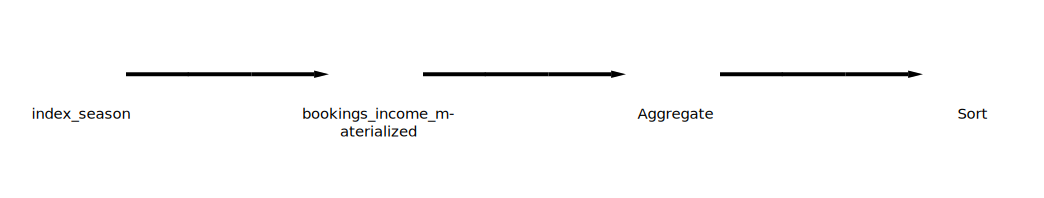

In [6]:
SVG(filename='imagesIII/explain_plan_1590950213013.svg')

The system R is now using the bitmap index on seasons, like we planned, greatly improving performance. 

### Query 2

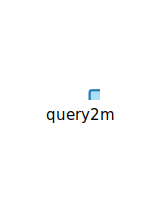

In [9]:
SVG(filename='imagesIII/q2_plan2.svg')

Implementing a materialized view (given that the appserver's PostgreSQL version does not support this, a new equivalent data table was created), the querying of data becomes a simple subsetting of the table columns and the query is reduced to a quick sequential scan.

### Query 4

In [37]:
index_sql = """
CREATE INDEX score ON metrics(score desc);
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(topn_sql, conn)
if success is True: print('Index Created')

Index Created


<img src="imagesIII/top10_after.png" width="1000"/>

### d. Discussion

With the full use of the data warehouse what are the expectation for its growth in 1, 5 and 10 years. Identify what approaches would be used to address such an increase in data.

For query 1, if we were under a real business framework, we would have data on past bookings. We would want to make income analysis for each year, and compare different years, in order to elaborate expansion strategies and 'predict' the current year's demand. We could probably have these aggregations as materialized views for each year, since their size is not very big. As for current year monitorization of bookings, since bookings are made very frequently on the website, this could be a concern. In a 5 or 10 years time, Airbnb could potentially have a considerable increase in bookings, having more listings available. This growing of data and the need to compute the query frequently increase the urgency of implementing the previously described optimization strategies, such as creating materialized views and using OLAP extensions in SQL.

For queries 2 and 3, changes occur in a long term timeframe. It's not expected to observe drastic changes in small periods of time, and so the increase in data is very gradual. Over 5 and 10 years, the amount of listings registered in the system is expected to grow quite a lot, as Airbnb continues to grow in popularity amongst vacationing options. Query 3 will reflect this change in the number of listings available. It will be interesting to witness the places with higher rate growth in listed properties. Will downtown Lisbon continue to dominate and continuously increase, or will it be "saturated" and no longer have much real estate available for this purpose, and instead, see an increase in the suburbs and surrounding areas of the Greater Metropolitan Area? Query 2 could expose differences in the market trends: although it's very unlikely the majority of properties will stop being Portuguese-owned, perhaps larger shares of foreigners will own properties to rent in Lisbon, or perhaps given the recent COVID-19 crisis, investment in properties will decrease, shifting money from the tourism market to other markets. For both queries, increases in data will of course impact query speed, but in a way that is not worrying, as these are queries performed infrequently.

Query 4 is similar to query 1 in regarding to income, but we could create different metrics and KPI’s for both past income and predicted future income. The second query due to its volubility should then be analyzed regularly, generating a sort of time series analysis, similar to the stock market.
In the first year we do not except a major growth and having in mind COVID-19 even less so. In 5 to 10 years we expect to have an increase in data, and if these was a real case scenario, for an increase in the company’s performance, by following the KPI’s closely. These queries are, in our opinion very well optimized, and would be difficult to optimize more using Postgres. 
Given the dimension of the Airbnb, to go beyond, and enter big data analytics, probably using apache spark would be the best option. This service would offer tools for increase performance in all parts of analytics, querying, analysis and even data streaming to always ensure up to date dashboards.


The existence of indexes in most, if not all, data of interest for our OLAP queries led to already great efficiency, with little room for improvement.

# 3. Critical assessment

###  a. Phases comparison

In phase I, the chosen dataset has its limitations in the ways we can model the data. This is mainly due to the fact that it is a product of web scraping and, as such, important information for business intelligence is unattainable. Certain initial plans had to be changed. However, it also allowed us to later explore particular cases of data warehouse design and dimension modelling, such as the factless fact table Bookings.

In Phase II, each ETL process could have been optimised to perform better, as well as have cleaner code. For example, some ETL pipelines for certain dimensions were designed in such a way as to allow for constant reuse of the code without redundant calculations (it works for either first insert of the data/dimension construction, or for any subsequent data insertions), whereas other pipelines were divided into dimension construction/first data insertion + subsequent data insertions. However, we designed it in such a way that makes all parts work as a subsystem of a whole pipeline, making sure the process runs as smoothly as possible.

In Phase III, we realised that we do not have access to the most relevant data or KPIs for Business Intelligence but we chose queries that could serve as a proof-of-concept of the potential of this data warehouse, keeping the analytics perspective in mind at all times. We also invested some time in designing potential visualisations of our query results, as communicating results through a visual medium greatly increases understandability and can help detect patterns in the data.

### b. Grade proposal

We propose a 19 because we were creative and innovative in our methods. We were concerned about the reproducibility and automation of the ETL and we were critical of our limitations. Even though we discovered that the data available from web scrapping crippled our options, we still pursued analysis that seemed interesting in the implementation point of view and that could be extended to other assays once we have more data on clients.

In our ETL we took special care in analysing possible scenarios on inserting data and updating the database. We made an effort to integrate the theory learned in our classes and explore the most complex methods, namely on choosing SCD, our star schema with the factless fact table Bookings, cube operations and SQL OLAP extensions.

We could have done better in making the code more cohesive and coordinating the several ETLs. If we had more time we could've invested in improving the several issues flagged throughout the phases, but we believe that we achieved the expectations, being that these details would be additional improvements that weren't necessarily vital for the objectives of the project.